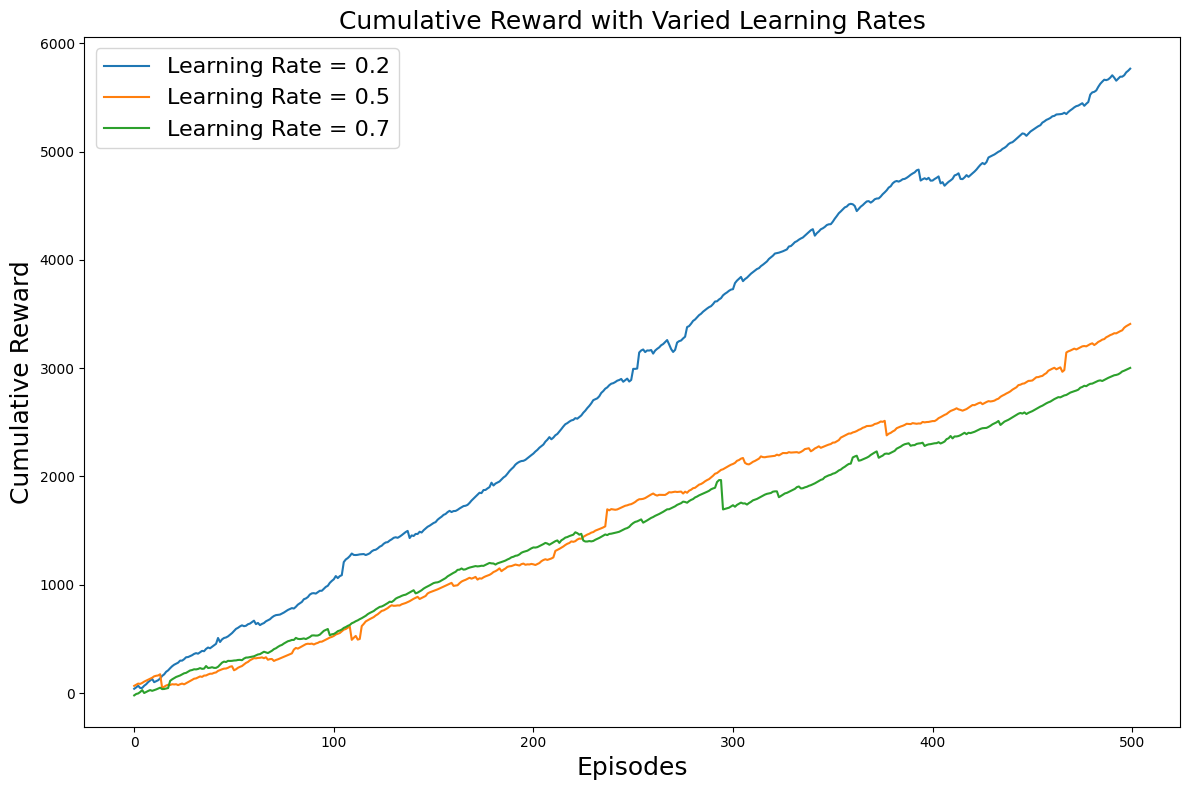

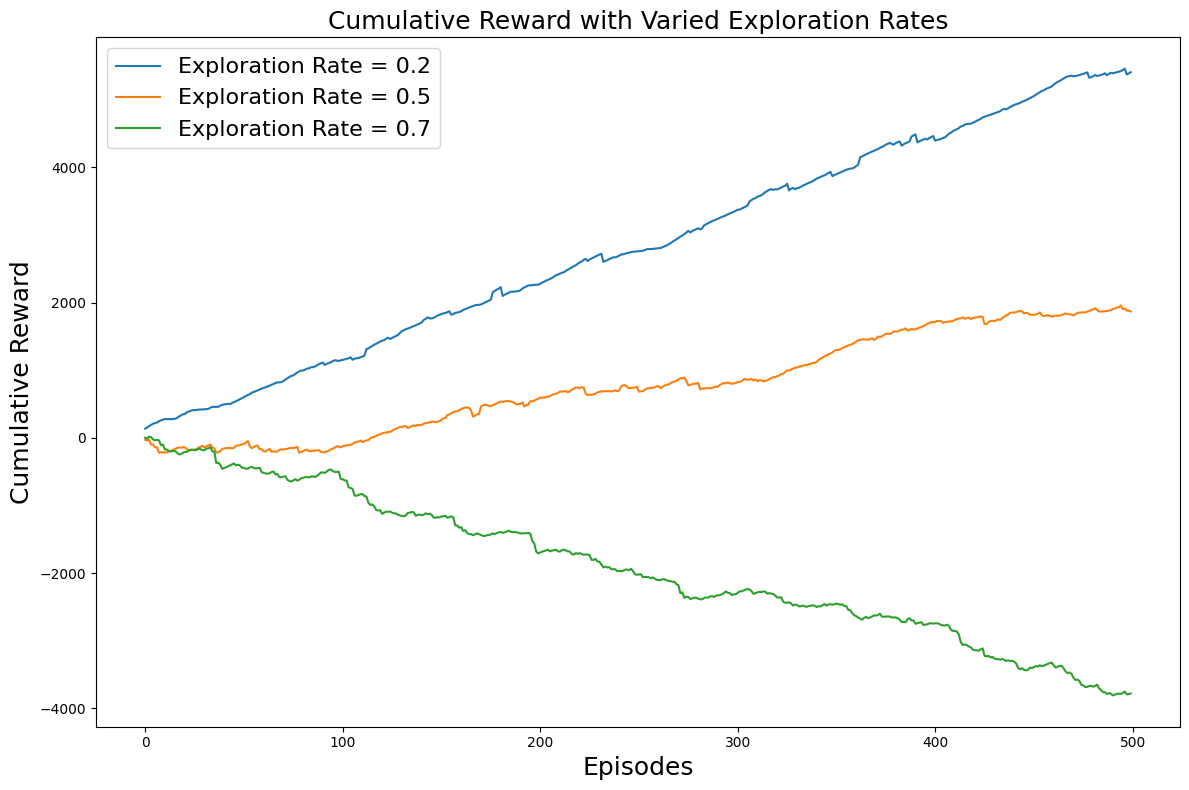

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Grid World Configuration
BOARD_ROWS = 5
BOARD_COLS = 5

# Special State Coordinates
WIN_STATE = (4, 4)      # Goal state
JUMP_STATE = (1, 3)     # Special state with higher reward
START = (1, 0)          # Starting position
OBSTACLES = [(2, 2), (2, 3), (2, 4), (3, 2)]  # Blocked cells

class State:
    def __init__(self, state=START):
        """
        Initialize the grid world state
        
        Args:
            state (tuple): Initial position of the agent
        """
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.board[1, 1] = -1  # Mark initial obstacle
        self.state = state
        self.isEnd = False

    def give_reward(self):
        """
        Provide reward based on current state
        
        Returns:
            int: Reward value
        """
        if self.state == WIN_STATE:
            return +10  # Large reward for reaching goal
        elif self.state == JUMP_STATE:
            return +5   # Medium reward for special jump state
        else:
            return -1   # Small negative reward to encourage efficient paths

    def is_end_func(self):
        """
        Check if current state is the end state
        """
        if self.state == WIN_STATE:
            self.isEnd = True

    def nxt_position(self, action):
        """
        Determine next position based on action
        
        Args:
            action (str): Movement action
        
        Returns:
            tuple: Next state coordinates
        """
        # Define next state based on action
        if action == "up":
            nxt_state = (self.state[0] - 1, self.state[1])
        elif action == "down":
            nxt_state = (self.state[0] + 1, self.state[1])
        elif action == "left":
            nxt_state = (self.state[0], self.state[1] - 1)
        elif action == "jump":
            nxt_state = (self.state[0] + 2, self.state[1])
        else:  # right
            nxt_state = (self.state[0], self.state[1] + 1)

        # Validate next state (within bounds and not an obstacle)
        if (0 <= nxt_state[0] < BOARD_ROWS and 
            0 <= nxt_state[1] < BOARD_COLS and 
            nxt_state not in OBSTACLES):
            return nxt_state
        
        # Return current state if move is invalid
        return self.state

class Agent:
    def __init__(self, learning_rate=0.3, exploration_rate=0.3):
        """
        Initialize Q-learning agent
        
        Args:
            learning_rate (float): Rate of learning from rewards
            exploration_rate (float): Probability of exploring random actions
        """
        self.states = []
        self.actions = ["up", "down", "left", "right", "jump"]
        self.State = State()
        
        # Learning parameters
        self.lr = learning_rate      # Learning rate (alpha)
        self.exp_rate = exploration_rate  # Exploration rate (epsilon)
        
        # Initialize state values
        self.state_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.state_values[(i, j)] = 0

        # Tracking rewards
        self.cumulative_rewards = []
        self.episode_rewards = []

    def choose_action(self):
        """
        Select action using epsilon-greedy strategy
        
        Returns:
            str: Selected action
        """
        # Exploration: random action
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
            # Ensure 'jump' is only used at specific state
            while action == 'jump' and self.State.state != JUMP_STATE:
                action = np.random.choice(self.actions)
            return action
        
        # Exploitation: choose best known action
        mx_nxt_reward = float('-inf')
        action = ""
        
        for a in self.actions:
            # Skip invalid actions
            if self.State.nxt_position(a) == self.State.state:
                continue
            
            # Skip jump if not at jump state
            if a == "jump" and self.State.state != JUMP_STATE:
                continue
            
            # Find action with maximum next reward
            nxt_reward = self.state_values[self.State.nxt_position(a)]
            if nxt_reward > mx_nxt_reward:
                action = a
                mx_nxt_reward = nxt_reward
        
        return action

    def take_action(self, action):
        """
        Execute action and transition to next state
        
        Args:
            action (str): Action to take
        
        Returns:
            State: New state after action
        """
        position = self.State.nxt_position(action)
        return State(state=position)

    def reset(self):
        """
        Reset agent for a new episode
        """
        self.states = []
        self.State = State()

    def play(self, rounds=100):
        """
        Train agent for specified number of episodes
        
        Args:
            rounds (int): Number of training episodes
        
        Returns:
            list: Cumulative rewards per episode
        """
        self.cumulative_rewards = []
        self.episode_rewards = []
        total_reward = 0

        for i in range(rounds):
            episode_reward = 0
            
            # Continue episode until end state
            while not self.State.isEnd:
                # Choose and take action
                action = self.choose_action()
                self.states.append(self.State.nxt_position(action))
                
                # Transition to next state
                self.State = self.take_action(action)
                self.State.is_end_func()
                
                # Get reward
                reward = self.State.give_reward()
                episode_reward += reward
                
                # Update state value
                self.state_values[self.State.state] = reward

            # Backpropagate rewards
            for s in reversed(self.states):
                reward = self.state_values[s] + self.lr * (reward - self.state_values[s])
                self.state_values[s] = round(reward, 4)

            # Track rewards
            total_reward += episode_reward
            self.cumulative_rewards.append(total_reward)
            self.episode_rewards.append(episode_reward)
            
            # Reset for next episode
            self.reset()

        return self.cumulative_rewards
    


    def plot_cumulative_rewards(self, rounds=500):
        """
        Plot cumulative rewards across episodes
        
        Args:
            rounds (int): Number of training episodes
        """
        plt.figure(figsize=(12, 8))
        
        # Different learning rates
        learning_rates = [0.2, 0.5, 0.7]
        for lr in learning_rates:
            agent = Agent(learning_rate=lr, exploration_rate=0.3)
            cumulative_rewards = agent.play(rounds)
            plt.plot(cumulative_rewards, label=f'Learning Rate = {lr}')
        
        plt.title('Cumulative Reward with Varied Learning Rates', fontsize=18)
        plt.xlabel('Episodes', fontsize=18)
        plt.ylabel('Cumulative Reward', fontsize=18)
        plt.legend(fontsize=16)
        plt.tight_layout()
        plt.show()

        # Different exploration rates
        plt.figure(figsize=(12, 8))
        exploration_rates = [0.2, 0.5, 0.7]
        for exp in exploration_rates:
            agent = Agent(learning_rate=0.3, exploration_rate=exp)
            cumulative_rewards = agent.play(rounds)
            plt.plot(cumulative_rewards, label=f'Exploration Rate = {exp}')
        
        plt.title('Cumulative Reward with Varied Exploration Rates', fontsize=18)
        plt.xlabel('Episodes', fontsize=18)
        plt.ylabel('Cumulative Reward', fontsize=18)
        plt.legend(fontsize=16)
        plt.tight_layout()
        plt.show()

    def plot_state_values(self):
        """
        Visualize state values as a heatmap
        """
        q_values = np.zeros((BOARD_ROWS, BOARD_COLS))
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                q_values[i, j] = self.state_values[(i, j)]
        
        plt.figure(figsize=(8, 6))
        im = plt.imshow(q_values, cmap='RdYlBu_r', origin='upper')
        plt.colorbar(im)
        
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                plt.text(j, i, f'{q_values[i, j]:.2f}', 
                         ha='center', va='center', 
                         color='black' if q_values[i, j] < np.median(q_values) else 'white')
        
        plt.title('State Values Heatmap', fontsize=16)
        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    # Create agent and run training
    agent = Agent()
    
    # Play and get cumulative rewards
    cumulative_rewards = agent.play(rounds=500)
    
    # Plot rewards and state values
    agent.plot_cumulative_rewards()
    # agent.plot_state_values()